# Turning point analysis
- Work flow
    1. turn tick data into daily data
        - findataflow
    1. For each maturity
        - detect turing points (N)
            - N = 1, 2, 3, ...
        - combine turning points
    1. summarize turning points by day-to-maturity
        - frequency
        - slope
        - duration
        - optimal lambda


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# pretty print for consecutive dfs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

## turn tick data into daily data

In [4]:
import config as cfg
from datetime import datetime

def get_maturity(series_date):
    settlements = pd.to_datetime(pd.read_csv(cfg.PATH_SETTLEMENTS).settlement).dt.date
    maturities = series_date.where(series_date.isin(settlements)).fillna(method='bfill')
    maturities.where(maturities > settlements.min(), inplace = True)
    return maturities

#TODO: need more input for settlement dates

In [5]:
from findataflow.dataprocs import resample

In [6]:
df_ohlc = resample.get_OHLCV_given_frequency(symbol='TXF', freq='1D')
df_ohlc.reset_index(inplace=True)
df_ohlc.rename(columns={'index': 'tx_datetime'}, inplace=True)
df_ohlc['tx_datetime'] = df_ohlc.tx_datetime.dt.date
df_ohlc['maturity'] = get_maturity(df_ohlc.tx_datetime)
df_ohlc.head()

transformed OHLCV at frequency 1D
reading cache of TXF in 1D OHLCV


,tx_datetime,open,high,low,close,vol,maturity
0,2011-01-03,9000.0,9030.0,8995.0,9020.0,122732,NaN
1,2011-01-04,9030.0,9030.0,8974.0,8978.0,124896,NaN
2,2011-01-05,8967.0,9005.0,8791.0,8838.0,331662,NaN
3,2011-01-06,8859.0,8876.0,8815.0,8869.0,165020,NaN
4,2011-01-07,8866.0,8883.0,8727.0,8753.0,257504,NaN


In [7]:
df_ohlc.tail()

,tx_datetime,open,high,low,close,vol,maturity
1995,2019-02-14,10044.0,10124.0,10034.0,10080.0,193056,2019-02-20
1996,2019-02-15,10040.0,10116.0,10022.0,10042.0,223160,2019-02-20
1997,2019-02-18,10111.0,10161.0,10098.0,10135.0,193704,2019-02-20
1998,2019-02-19,10123.0,10158.0,10104.0,10142.0,143182,2019-02-20
1999,2019-02-20,10183.0,10262.0,10177.0,10256.0,136116,2019-02-20


## turing point at maturity-level
- detect turing points (N)
    - N = 1, 2, 3, ...
- combine turning points

In [8]:
def get_marked_turnpt(prc_ohlc, N): 
    assert 'tx_datetime' in prc_ohlc.columns, 'tx_datetime is not in column name list'
    assert 'low' in prc_ohlc.columns, 'low is not in column name list'
    assert 'high' in prc_ohlc.columns, 'high is not in column name list'
    
    df_prc = prc_ohlc[['tx_datetime']].copy()
    window = prc_ohlc[['close']].rolling(window = N * 2 + 1, center = True, min_periods = N+1)
    df_prc['N'] = N
    df_prc['is_turnpt_upward'] = (prc_ohlc.close == window.min().close).astype(int)
    df_prc['is_turnpt_downward'] = (prc_ohlc.close == window.max().close).astype(int)
    df_prc['is_turnpt'] = df_prc.is_turnpt_upward + df_prc.is_turnpt_downward * (-1)
    return df_prc

def get_combined_turnpt(df_turnpt_ohlc):
    rows_turnpt = []
    row_candidate = None
    for idx, row_current in df_turnpt_ohlc.iterrows():
        # for first turning point
        if row_current.is_turnpt == 0: 
            continue

        # for first turning point
        if row_candidate is None: 
            row_candidate = row_current
            continue    

        # for every following turning points
        if row_candidate.is_turnpt != row_current.is_turnpt:
            rows_turnpt.append(row_candidate[['N', 'tx_datetime', 'is_turnpt_upward', 'is_turnpt_downward']])
            row_candidate = row_current
        else:
            direction = row_candidate.is_turnpt
            if direction > 0:
                row_candidate = row_current if (row_current.close < row_candidate.close) else row_candidate
            elif direction < 0:
                row_candidate = row_current if (row_current.close > row_candidate.close) else row_candidate
            else:
                raise ValueError('direction can only be -1 or 1.')
    df_turnpt_combined = pd.DataFrame(rows_turnpt)
    df_turnpt_ohlc_combined = df_turnpt_combined.merge(df_turnpt_ohlc[['tx_datetime'] + [col for col in df_turnpt_ohlc.columns if col not in df_turnpt_combined.columns]], on='tx_datetime', how='left')
    return df_turnpt_ohlc_combined

def plot_turnpt(df_turnpt_ohlc, N):
    df_plot = df_turnpt_ohlc.query(f'N == {N}').copy()
    df_plot.set_index('tx_datetime', inplace=True)
    def find_loc(df, dates):
        return [df.index.get_loc(date) for date in dates]

    dates_upward = df_plot.query('is_turnpt_upward==1').index
    df_plot.close.plot.line(figsize=(20, 5), color='white', markevery=find_loc(df_plot, dates_upward), marker='^', markerfacecolor='red', markeredgewidth=0.0)

    dates_downward = df_plot.query('is_turnpt_downward==1').index
    df_plot.close.plot.line(figsize=(20, 5), color='black', markevery=find_loc(df_plot, dates_downward), marker='v', markerfacecolor='green', markeredgewidth=0.0)
    plt.title(f'N: {N}')

In [9]:
df_turnpt = pd.concat([get_marked_turnpt(df_grp, N = 1) for grp, df_grp in df_ohlc.groupby('maturity')])
df_turnpt_ohlc =  df_turnpt.merge(df_ohlc, on='tx_datetime', how='left')
df_turnpt_ohlc

,tx_datetime,N,is_turnpt_upward,is_turnpt_downward,is_turnpt,open,high,low,close,vol,maturity
0,2012-12-20,1,0,1,-1,7631.0,7633.0,7556.0,7560.0,157898,2013-01-16
1,2012-12-21,1,1,0,1,7565.0,7578.0,7472.0,7491.0,215348,2013-01-16
2,2012-12-22,1,0,1,-1,7556.0,7558.0,7523.0,7525.0,60190,2013-01-16
3,2012-12-24,1,1,0,1,7500.0,7564.0,7491.0,7518.0,102296,2013-01-16
4,2012-12-25,1,0,1,-1,7555.0,7688.0,7538.0,7674.0,171954,2013-01-16
...,...,...,...,...,...,...,...,...,...,...,...
1506,2019-02-14,1,0,0,0,10044.0,10124.0,10034.0,10080.0,193056,2019-02-20
1507,2019-02-15,1,1,0,1,10040.0,10116.0,10022.0,10042.0,223160,2019-02-20
1508,2019-02-18,1,0,0,0,10111.0,10161.0,10098.0,10135.0,193704,2019-02-20
1509,2019-02-19,1,0,0,0,10123.0,10158.0,10104.0,10142.0,143182,2019-02-20


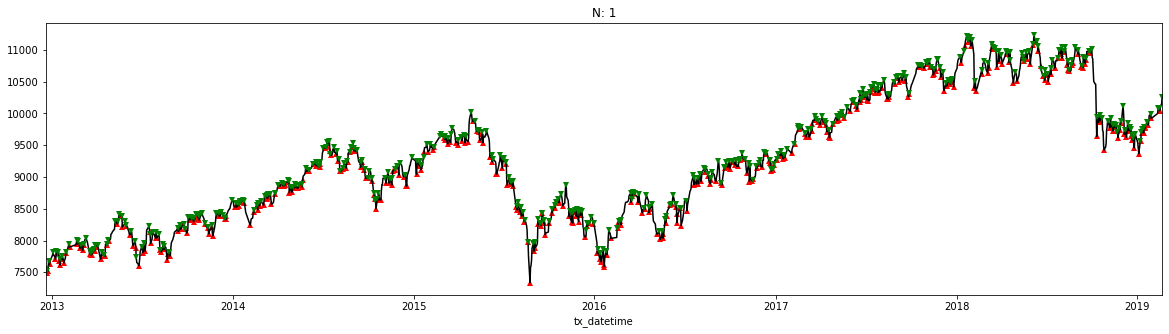

In [10]:
plot_turnpt(df_turnpt_ohlc, N = 1)

In [ ]:
df_turnpt_ohlc_combined = get_combined_turnpt(df_turnpt_ohlc)
plot_turnpt(df_turnpt_ohlc_combined, N = 1)